In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os

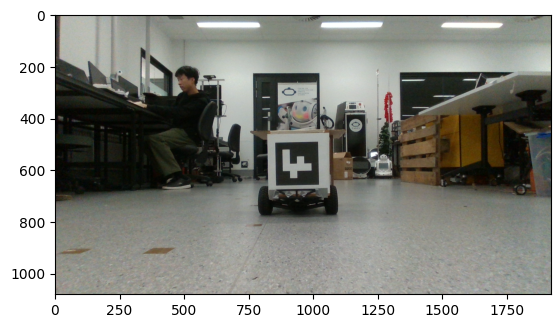

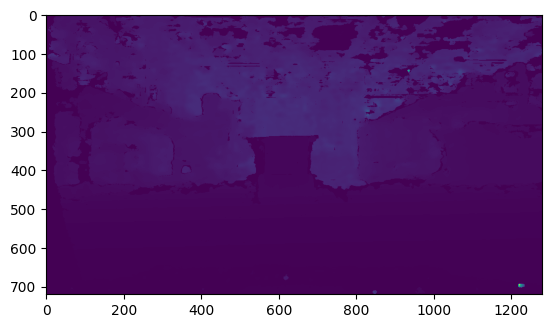

In [2]:
working_dir = os.getcwd()

color = cv2.imread(f"{working_dir}/perception_debug/run3/ego/24_09_29_23:54:58/color/1727607303484172288.png")
depth = np.load(f"{working_dir}/perception_debug/run3/ego/24_09_29_23:54:58/depth/1727607303484172288.npy")

# Show the color image
plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))

# Show the depth image
plt.figure()
plt.imshow(depth)

In [3]:
# # Attempt to align the depth image with the color image by scaling and cropping it
# FACTOR = 2.1
# depth = cv2.resize(depth, (int(depth.shape[1] * FACTOR), int(depth.shape[0] * FACTOR)))

# # Crop the depth image to the same size as the color image centered around the center of the image
# depth = depth[depth.shape[0]//2 - color.shape[0]//2 : depth.shape[0]//2 + color.shape[0]//2, depth.shape[1]//2 - color.shape[1]//2 : depth.shape[1]//2 + color.shape[1]//2]

# # Overlay the depth image on the color image
# plt.figure()
# plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
# plt.imshow(depth, alpha=0.5)

# Use homography to transform the depth image such that it aligns with the color image

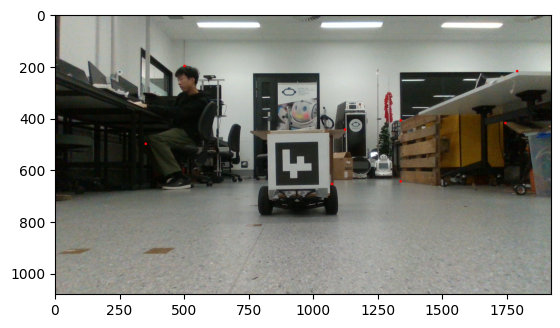

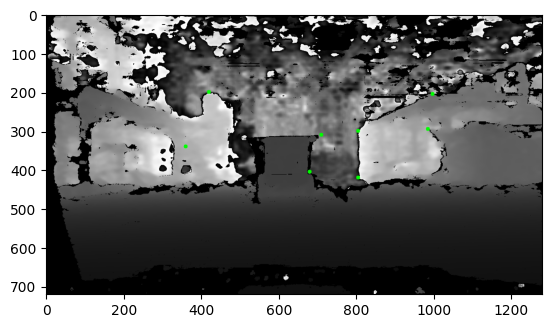

In [4]:
pts_color = np.array([[500, 200], [1785, 220], [1120, 445], [1335, 645], [350, 500], [1335, 410], [1740, 420], [1070, 655]])
pts_depth = np.array([[420, 200], [997, 205], [710, 310], [805, 420], [360, 340], [805, 300], [985, 295], [680, 405]])

# Draw the points on the images to check if they are correct
color_pts = color.copy()

MAX_THRESHOLD = 5000
depth_pts = (depth / MAX_THRESHOLD * 255).astype(np.uint8)
depth_pts = cv2.cvtColor(depth_pts, cv2.COLOR_GRAY2RGB)
for i in range(8):
    cv2.circle(color_pts, tuple(pts_color[i]), 5, (0, 0, 255), -1)
    cv2.circle(depth_pts, tuple(pts_depth[i]), 5, (0, 255, 0), -1)

plt.figure()
plt.imshow(cv2.cvtColor(color_pts, cv2.COLOR_BGR2RGB))

plt.figure()
plt.imshow(depth_pts)

In [5]:
intrinsics = np.loadtxt(f"{working_dir}/perception_debug/run3/ego/24_09_29_23:54:58/color/intrinsics.txt")
dist_coeffs = np.loadtxt(f"{working_dir}/perception_debug/run3/ego/24_09_29_23:54:58/color/dist_coeffs.txt")

# Undistort the images
new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (color.shape[1], color.shape[0]), alpha=1)
undistorted_color = cv2.undistort(color, intrinsics, dist_coeffs, None)

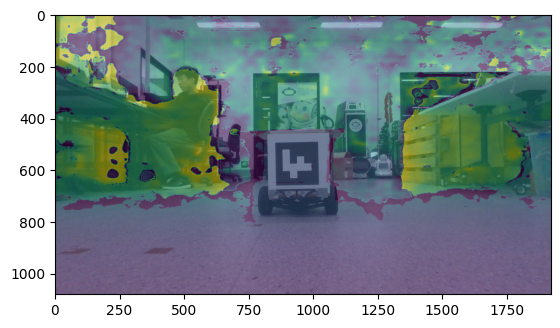

In [6]:
# Find the homography matrix
H, _ = cv2.findHomography(pts_depth, pts_color)

# Warp the depth image
depth_warped = cv2.warpPerspective(depth, H, (color.shape[1], color.shape[0]))
depth_warped = (depth_warped / MAX_THRESHOLD * 255).astype(np.uint8)

# Overlay the depth image on the color image
plt.figure()
plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
plt.imshow(depth_warped, alpha=0.5)

In [7]:
# print H to be used in processing scripts
H

array([[ 2.31383461e+00,  1.29787678e-02, -4.69764264e+02],
       [ 1.42182154e-02,  2.20740813e+00, -2.38196239e+02],
       [ 1.51742258e-05,  9.06675925e-05,  1.00000000e+00]])

array([[ 4.3093820234694441e-01, -1.0743690101400583e-02,
         1.9988026083233976e+02],
       [-3.4476255716975181e-03,  4.4871665720989579e-01,
         1.0526304884013102e+02],
       [-6.2265656596329512e-06, -4.0521031852012964e-05,
         9.8742302457834497e-01]])

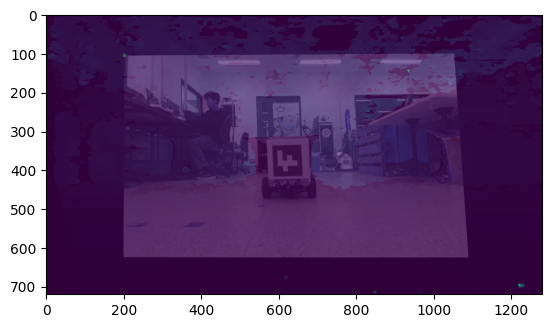

In [8]:
# Now try warping the color image to the depth image

# Find the homography matrix
H_inv = np.linalg.inv(H)

# Warp the color image
color_warped = cv2.warpPerspective(color, H_inv, (depth.shape[1], depth.shape[0]))

# Test warping a point from the color image to the depth image
center_x = 0
center_y = 0
depth_x = (H_inv[0, 0] * center_x + H_inv[0, 1] * center_y + H_inv[0, 2]) / (H_inv[2, 0] * center_x + H_inv[2, 1] * center_y + H_inv[2, 2])
depth_y = (H_inv[1, 0] * center_x + H_inv[1, 1] * center_y + H_inv[1, 2]) / (H_inv[2, 0] * center_x + H_inv[2, 1] * center_y + H_inv[2, 2])
cv2.circle(color_warped, (int(depth_x), int(depth_y)), 5, (0, 255, 0), -1)

# Overlay the color image on the depth image
plt.figure()
plt.imshow(depth)
plt.imshow(color_warped, alpha=0.3)

# print H_inv to be used in processing scripts with high precision
np.set_printoptions(precision=16)
H_inv # Use in process_tracking.py script

# Test for other pairs of color/depth frames

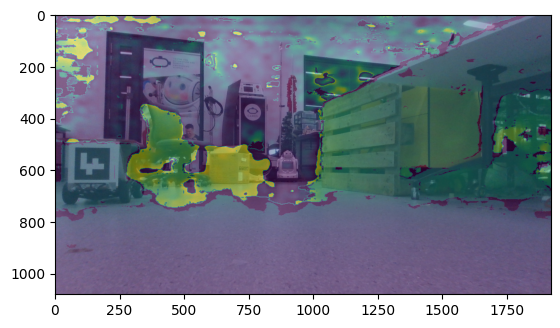

In [9]:
test_color1 = cv2.imread(f"{working_dir}/perception_debug/run3/ego/24_09_29_22:45:36/color/1727603148784676608.png")
test_depth1 = np.load(f"{working_dir}/perception_debug/run3/ego/24_09_29_22:45:36/depth/1727603148784676608.npy")

new_depth_warped = cv2.warpPerspective(test_depth1, H, (color.shape[1], color.shape[0]))
new_depth_warped = (new_depth_warped / MAX_THRESHOLD * 255).astype(np.uint8)

plt.figure()
plt.imshow(cv2.cvtColor(test_color1, cv2.COLOR_BGR2RGB))
plt.imshow(new_depth_warped, alpha=0.5)

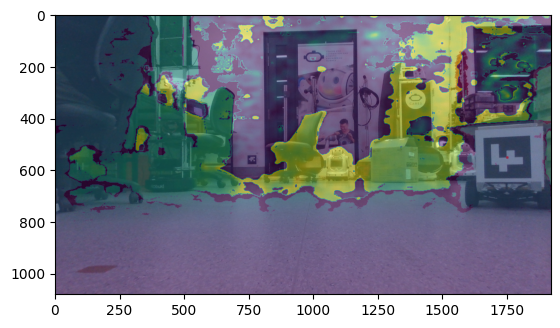

In [10]:
test_color2 = cv2.imread(f"{working_dir}/perception_debug/run3/ego/24_09_29_23:54:58/color/1727607312489773312.png")
test_depth2 = np.load(f"{working_dir}/perception_debug/run3/ego/24_09_29_23:54:58/depth/1727607312489773312.npy")

new_depth_warped = cv2.warpPerspective(test_depth2, H, (color.shape[1], color.shape[0]))
new_depth_warped = (new_depth_warped / MAX_THRESHOLD * 255).astype(np.uint8)

# Plot marker center point on the image
point = 1747.40658569336, 553.803527832031

cv2.circle(test_color2, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)

plt.figure()
plt.imshow(cv2.cvtColor(test_color2, cv2.COLOR_BGR2RGB))
plt.imshow(new_depth_warped, alpha=0.5)

# Sanity check method by plotting depth over time
This is now broken as we no longer display the x, y image coordinates of the marker's center.

In [11]:
import pandas as pd

# Read time as integer
opp_rel_poses = pd.read_csv(f"{working_dir}/perception_debug/run3/ego/24_09_29_23:54:58/color/opp_rel_poses.csv", index_col="time")
opp_rel_poses

,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,depth_tx,depth_ty,depth_tz
time,,,,,,,,,,,,,
1727607301750235904,-0.714605,-0.699486,0.007701,0.000584,-2.244164,-2.196682,0.024184,-0.022069,0.007104,1.251344,-0.009956,0.008540,1.269484
1727607301783894272,0.714445,0.699330,-0.021408,0.006993,2.234556,2.187281,-0.066957,-0.022111,0.006963,1.250793,-0.009948,0.008532,1.268484
1727607301817347072,0.714584,0.699397,-0.012724,0.007204,2.234694,2.187199,-0.039793,-0.022066,0.007019,1.251292,-0.009951,0.008532,1.268484
1727607301884259840,0.714606,0.699505,-0.005102,0.002143,2.241943,2.194567,-0.016008,-0.022057,0.007077,1.251450,-0.010036,0.008532,1.272484
1727607301951181056,0.714614,0.699391,-0.012734,0.004079,2.239215,2.191515,-0.039902,-0.022114,0.007046,1.251454,-0.009977,0.008539,1.268484
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727607312356347904,-0.707583,-0.686816,0.114518,0.120397,-2.067179,-2.006507,0.334561,0.737066,-0.014620,1.297221,0.748365,-0.020085,1.295012
1727607312389704448,-0.706981,-0.687995,0.116459,0.115233,-2.071548,-2.015916,0.341241,0.736706,-0.014632,1.296543,0.747802,-0.020046,1.294011
1727607312423060480,-0.707045,-0.687935,0.115951,0.115707,-2.071169,-2.015192,0.339660,0.736480,-0.014603,1.296051,0.762607,-0.020452,1.320041


In [12]:
# Get depth at center of marker for all color/depth pairs
for row in opp_rel_poses.itertuples():
    index = row.Index
    color = cv2.imread(f"{working_dir}/perception_debug/run3/ego/24_09_29_23:54:58/color/{index}.png")
    depth = np.load(f"{working_dir}/perception_debug/run3/ego/24_09_29_23:54:58/depth/{index}.npy")
    depth_warped = cv2.warpPerspective(depth, H, (color.shape[1], color.shape[0]))
    row_center = int(row["image_x"]), int(row["image_y"])
    depth_center = depth_warped[row_center[1], row_center[0]]
    depth_center_5x5 = np.mean(depth_warped[row_center[1]-2:row_center[1]+3, row_center[0]-2:row_center[0]+3])
    opp_rel_poses.at[index, "depth_center"] = depth_center
    opp_rel_poses.at[index, "depth_center_5x5"] = depth_center_5x5

opp_rel_poses

TypeError: tuple indices must be integers or slices, not str

In [412]:
# Subtract start time from all times
with open(f"{working_dir}/perception_debug/run3/bev/24_09_29_23:55:00/start_time.txt") as f:
    start_time = int(f.read())

opp_rel_poses.index = opp_rel_poses.index - start_time

<AxesSubplot: xlabel='time', ylabel='depth_center'>

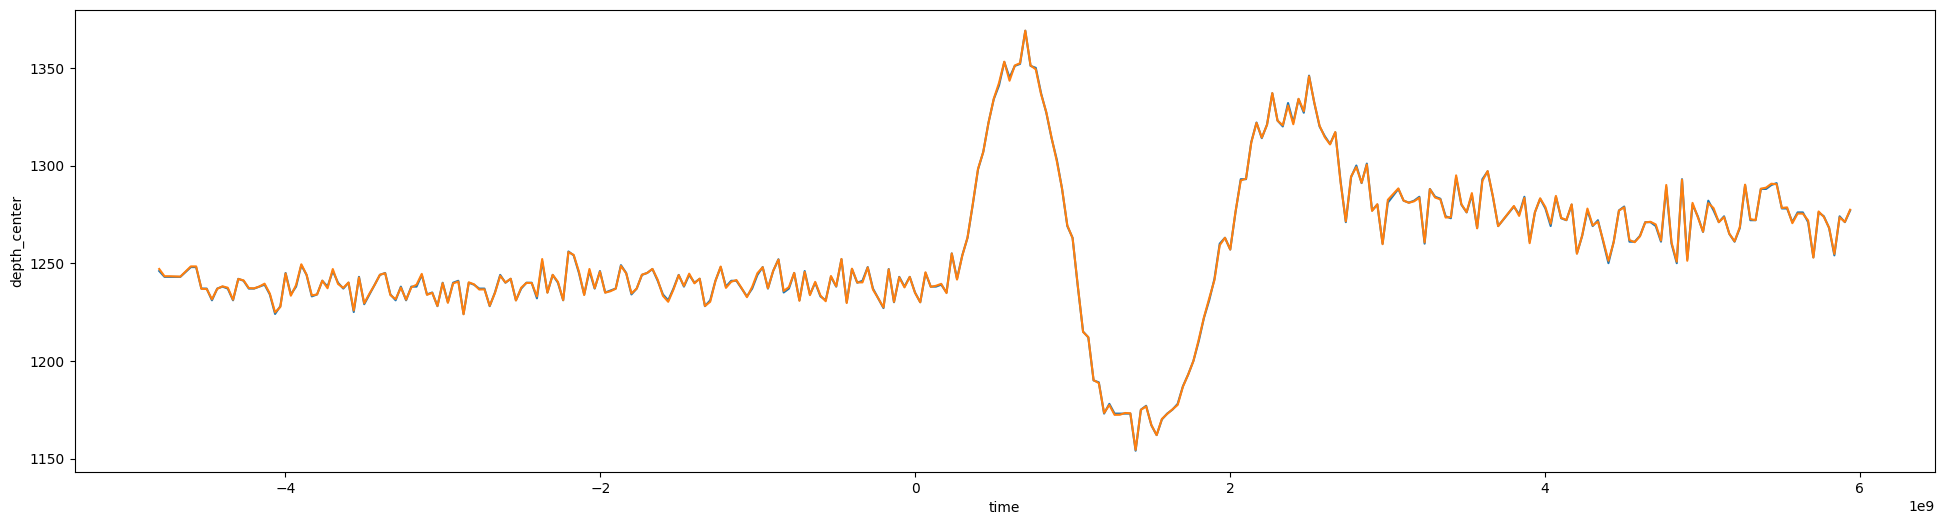

In [413]:
plt.figure(figsize=(24, 6))
sns.lineplot(data=opp_rel_poses, x=opp_rel_poses.index, y="depth_center")
sns.lineplot(data=opp_rel_poses, x=opp_rel_poses.index, y="depth_center_5x5")

This plot compares the depth values taken directly from a single pixel and the average of a 5x5 area, with the intention of discovering whether or not taking the average would reduce the noise. There's essentially no difference, and so there is no reason to waste computational resources performing this calculation.